In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [140]:
# Load data
df = pd.read_csv("pre_processed.csv")
df.head(1)

,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier,airport
0,8,89.0,13.0,2.25,1.6,3.16,0.0,5.99,2.0,1.0,1375.0,0,0


In [141]:
# Create target variable
df = df.dropna(subset=['arr_delay'])
df['is_delayed'] = (df['arr_delay'] > 15).astype(int)
X = df.drop(columns=['arr_delay', 'is_delayed'])
y = df['is_delayed']

In [142]:
# Show class balance
print("Class distribution:\n", y.value_counts())

Class distribution:
 is_delayed
1    164351
0      6872
Name: count, dtype: int64


In [143]:
# Identify column types
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [144]:
# Preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num_cols),
    (make_pipeline(SimpleImputer(strategy='most_frequent'),
                   OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), cat_cols)
)

In [145]:
# Classifiers with improvements
lr = LogisticRegression(max_iter=2000, solver='liblinear',C=0.5,class_weight='balanced')
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=1.5, random_state=42)


In [146]:
# Voting ensemble (soft voting)
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2, 2]
)


In [147]:
# Full pipeline
pipeline = make_pipeline(preprocessor, voting_clf)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

In [148]:
X_test.head(1)

,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,carrier,airport
157160,7,305.0,58.0,27.68,1.85,7.48,0.0,20.99,2.0,0.0,13,132


In [149]:
# Evaluation
print("\n=== Voting Ensemble Classifier ===")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["On Time", "Delayed"], zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


=== Voting Ensemble Classifier ===
Classification Report:
              precision    recall  f1-score   support

     On Time       1.00      0.96      0.98      1396
     Delayed       1.00      1.00      1.00     32849

    accuracy                           1.00     34245
   macro avg       1.00      0.98      0.99     34245
weighted avg       1.00      1.00      1.00     34245

Confusion Matrix:
[[ 1335    61]
 [    2 32847]]


In [150]:
# Show predictions for a few test cases
results = X_test.copy()
results['Actual'] = y_test.map({0: "On Time", 1: "Delayed"}).values
results['Predicted'] = pd.Series(y_pred, index=X_test.index).map({0: "On Time", 1: "Delayed"}).values
print("\nSample Predictions:")
print(results[['Actual', 'Predicted']].sample(100))




Sample Predictions:
         Actual Predicted
2800    Delayed   Delayed
96945   Delayed   Delayed
34886   Delayed   Delayed
5526    Delayed   Delayed
35443   Delayed   Delayed
...         ...       ...
29268   Delayed   Delayed
88077   Delayed   Delayed
78184   Delayed   Delayed
130228  Delayed   Delayed
49982   Delayed   Delayed

[100 rows x 2 columns]


In [151]:
results = X_test.copy()
results['Actual'] = y_test.map({0: "On Time", 1: "Delayed"}).values
results['Predicted'] = pd.Series(y_pred, index=X_test.index).map({0: "On Time", 1: "Delayed"}).values


In [152]:
on_time_flights = results[results['Actual'] == 'On Time']
print("\nActual On-Time Flights Prediction Breakdown:")
print(on_time_flights['Predicted'].value_counts())



Actual On-Time Flights Prediction Breakdown:
Predicted
On Time    1335
Delayed      61
Name: count, dtype: int64


In [153]:
delayed_flights = results[results['Actual'] == 'Delayed']
print("\nActual Delayed Flights Prediction Breakdown:")
print(delayed_flights['Predicted'].value_counts())



Actual Delayed Flights Prediction Breakdown:
Predicted
Delayed    32847
On Time        2
Name: count, dtype: int64


In [154]:
correct_preds = results[results['Actual'] == results['Predicted']]
print("\nCorrect Predictions (Sample):")
print(correct_preds.sample(5))


Correct Predictions (Sample):
        month  arr_flights  arr_del15  carrier_ct  weather_ct  nas_ct  \
155507      8        154.0       26.0        9.01        0.14    7.85   
72918      12         48.0       11.0        6.00        1.00    1.00   
109677      2        455.0      131.0       30.08        5.87   56.94   
52551       1         31.0        3.0        0.37        0.00    1.63   
20031       8        372.0       60.0       16.92        2.06   24.98   

        security_ct  late_aircraft_ct  arr_cancelled  arr_diverted  carrier  \
155507         0.00              9.00            1.0           0.0        4   
72918          0.00              3.00            0.0           0.0       19   
109677         4.11             34.01            5.0           0.0        8   
52551          0.00              1.00            1.0           0.0       20   
20031          1.00             15.04            2.0           2.0       11   

        airport   Actual Predicted  
155507      371  D

In [155]:
wrong_preds = results[results['Actual'] != results['Predicted']]
print("\nIncorrect Predictions (Sample):")
print(wrong_preds.sample(5))



Incorrect Predictions (Sample):
        month  arr_flights  arr_del15  carrier_ct  weather_ct  nas_ct  \
2797        7          1.0        1.0        0.00        0.07    0.93   
122912      2          4.0        1.0        0.00        0.00    1.00   
68279       2          8.0        1.0        0.27        0.00    0.53   
28446       3          4.0        1.0        0.00        0.00    0.40   
98589       9          1.0        1.0        0.00        0.00    1.00   

        security_ct  late_aircraft_ct  arr_cancelled  arr_diverted  carrier  \
2797            0.0               0.0            0.0           0.0       13   
122912          0.0               0.0            0.0           0.0        5   
68279           0.0               0.2            0.0           0.0        6   
28446           0.0               0.6            0.0           0.0       10   
98589           0.0               0.0            0.0           0.0       15   

        airport   Actual Predicted  
2797         31 

In [156]:
from sklearn.metrics import accuracy_score

print("\nAccuracy for On-Time Flights:")
on_time_acc = accuracy_score(
    y_test[y_test == 0],
    pd.Series(y_pred, index=y_test.index)[y_test == 0]
)
print(f"{on_time_acc:.2%}")

print("\nAccuracy for Delayed Flights:")
delayed_acc = accuracy_score(
    y_test[y_test == 1],
    pd.Series(y_pred, index=y_test.index)[y_test == 1]
)
print(f"{delayed_acc:.2%}")



Accuracy for On-Time Flights:
95.63%

Accuracy for Delayed Flights:
99.99%


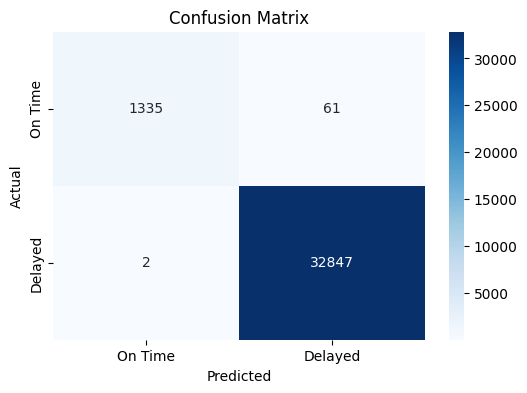

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["On Time", "Delayed"], yticklabels=["On Time", "Delayed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


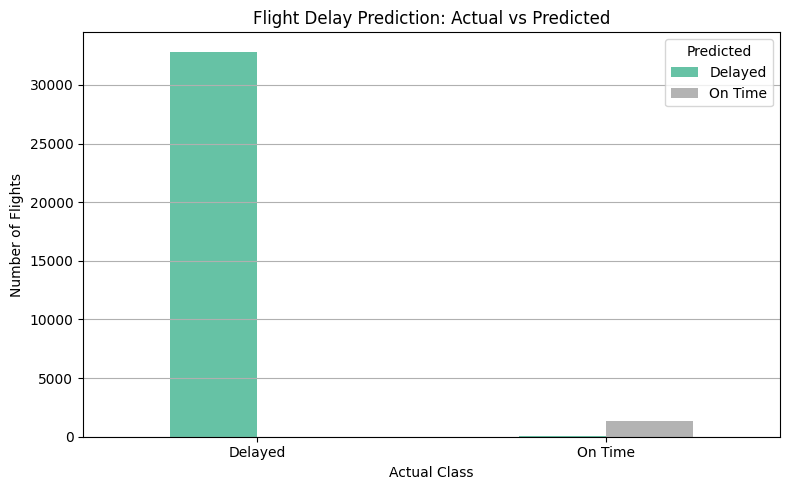

In [158]:
# Grouped count of Actual vs Predicted
results_grouped = results.groupby(["Actual", "Predicted"]).size().unstack(fill_value=0)

results_grouped.plot(kind="bar", figsize=(8, 5), colormap="Set2")
plt.title("Flight Delay Prediction: Actual vs Predicted")
plt.ylabel("Number of Flights")
plt.xlabel("Actual Class")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.legend(title="Predicted")
plt.tight_layout()
plt.show()


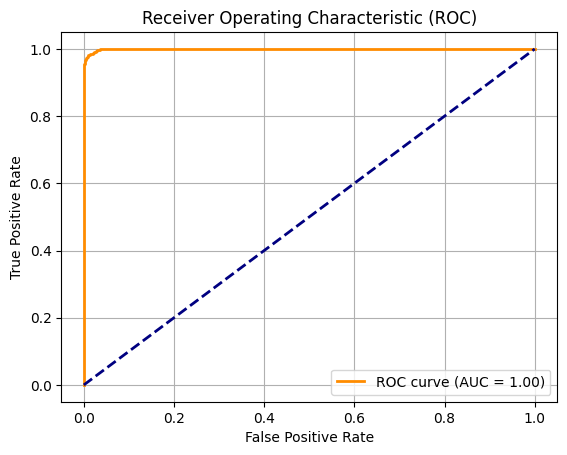

In [159]:
from sklearn.metrics import roc_curve, auc

y_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


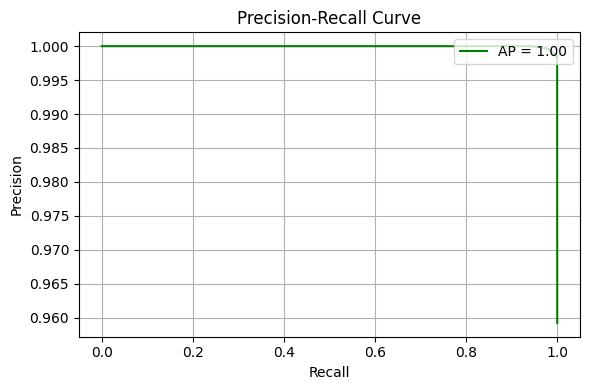

In [160]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [161]:
import joblib
joblib.dump(pipeline, "flight_delay_model.pkl")


['flight_delay_model.pkl']